## Notebook to prepping data for differential expression in single-cell data using GLMMTMB for each broad cell-type per brain region.

Ran into parallelization, from notebook, and scaling issues in using glmmTMB.

So this notebook was split from glmmtmb_diffexp.ipynb to just run up thru prepping and formatting jobs. Then jobs can be run in parallel somewhere else. Then run another notebook to integrate and post-process the results.

based on some of the observations related to pseudo-replicate and zero-inflation from

[Zimmerman KD, Espeland MA, Langefeld CD. A practical solution to pseudoreplication bias in single-cell studies. Nat Commun 2021;12:738.](https://pubmed.ncbi.nlm.nih.gov/33531494/)


In [1]:
!date

Mon Dec 11 17:11:34 UTC 2023


#### import libraries

In [2]:
from anndata import AnnData
from numpy import where
from pandas import DataFrame, concat
import scanpy as sc
import diffxpy.api as de
import json
# import concurrent.futures
from multiprocessing import Process

import warnings
warnings.simplefilter('ignore')

import random
random.seed(420)

#### set notebook variables

In [3]:
# naming
cohort = 'aging'

# directories for initial setup
wrk_dir = '/home/jupyter/brain_aging_phase1'
quants_dir = f'{wrk_dir}/demux'
results_dir = f'{wrk_dir}/results'

# in files
# in_file = f'{quants_dir}/{cohort}.pegasus.leiden_085.Age_group_young_old.h5ad'
in_file = f'{quants_dir}/{cohort}.pegasus.leiden_085.subclustered.h5ad'
glmmtmb_rscript_file = f'PATH/{cohort}/glmmTMB.R'

# out files
temp_r_in_file = '{this_dir}/{region}_{celltype}_glmmtmb_in_df_temp.csv'
temp_name_remap_json = '{this_dir}/{region}_{celltype}_gene_name_remap_temp.csv'
temp_r_out_file = '{this_dir}/{region}_{celltype}_glmmtmb_results_temp.csv'
diffxpy_out_file = '{this_dir}/{region}_{celltype}_de_diffxpy.csv'

# constants
DEBUG = True
min_cell_count = 3
# get cell counts by 'categories'
region_obs_feature = 'Brain_region'
celltype_obs_feature = 'new_anno'
testing = False
testing_sample_size = 100 #25

#### analysis functions

In [4]:
def subset_ad_by_type(data: AnnData, region_name: str, cell_name: str, type_name: str,
                      reapply_filter: bool=True, min_cell_count: int=3,
                      verbose: bool=False) -> AnnData:
    this_data = data[(data.obs[region_obs_feature] == region_name) & 
                     (data.obs[type_name] == cell_name)].copy()
    shape_before = this_data.shape
    if reapply_filter:
        sc.pp.filter_genes(this_data, min_counts=min_cell_count)
        sc.pp.filter_cells(this_data, min_counts=min_cell_count)
        shape_after = this_data.shape
    if verbose:
        print(f'subset complete, shape before and after: {shape_before} {shape_after}')
        print(this_data)
    return this_data

def convert_ad_to_df(data: AnnData, young_age_limit: float=30.0, 
                     verbose: bool=False) -> DataFrame:
    data_df = data.to_df()
    annots = data.obs[['Brain_region', 'Age','Age_group', 'pool_name', 
                       'Sample_id', 'Sex', 'donor_id']].copy()
    annots['old'] = where((annots['Age'] > young_age_limit), 1, 0)
    annots['female'] = where((annots['Sex'] == 'Female'), 1, 0)
    this_df = None
    if data_df.index.equals(annots.index):
        this_df = concat([data_df, annots], axis='columns')
        if verbose:
            print(f'anndata to pandas df complete: {this_df.shape}')
            print(this_df.shape)
            display(this_df.head())
    return this_df

def feature_detected(feature_col, features: list=None, df: DataFrame=None, 
                     min_cell_count: int=3, min_sample_det_rate: float=0.5,
                     verbose: bool=False):    
    good_feature = True
    if feature_col.name in features:
        nz_df = feature_col[feature_col > 0]
        ok_cnts = df.loc[nz_df.index].Sample_id.value_counts() > min_cell_count
        ok_sample_cnt = ok_cnts.sum()
        unique_sample_id_count = df['Sample_id'].nunique()
        good_feature = ok_sample_cnt / unique_sample_id_count >= min_sample_det_rate
        if verbose:
            print(feature_col.name, end=', ')
            print(f'nz_df.shape = {nz_df.shape}', end=', ')
            print(f'{ok_sample_cnt}/{unique_sample_id_count}', end=', ')
            print(good_feature)
    return good_feature

def poorly_detected_features(features: list=None, df: DataFrame=None, 
                             verbose=False) -> list:
    feature_detect_df = df.apply(feature_detected, features=features, df=df)
    bad_features = feature_detect_df.loc[~feature_detect_df].index.to_list()
    if verbose:
        print(f'bad features counts is {len(bad_features)}')
    return bad_features

def non_de_features(data: AnnData, region_name: str, 
                    cell_name: str, alpha: float=0.05) -> list:
    de_tt = de.test.t_test(data=data, grouping='Age_group')
    de_tt_summary = de_tt.summary()
    de_tt_summary.to_csv(diffxpy_out_file.format(this_dir=f'{quants_dir}', 
                                                 region=region_name.replace(" ", "_"), 
                                                 celltype=cell_name.replace(" ", "_")))
    ret_list = list(de_tt_summary[de_tt_summary['pval'] > alpha]['gene'].values)
    return ret_list

def save_df_for_glmmtmb_in_r(df: DataFrame, region_name: str, cell_name: str):
    # R doesn't like column names with hyphens in 
    # data frames when building formulas so replace temporarily
    # find features containing hyphen
    feats_w_hyphen = df.columns[df.columns.str.contains('-')]
    # make dictionary to do replace
    rename_cols = {x: x.replace('-', '_') for x in feats_w_hyphen}
    df = df.rename(columns=rename_cols)
    df.to_csv(temp_r_in_file.format(this_dir=f'{quants_dir}', 
                                    region=region_name.replace(" ", "_"), 
                                    celltype=cell_name.replace(" ", "_")))
    # save to gene remame dict
    json.dump(rename_cols, 
              open(temp_name_remap_json.format(this_dir=f'{quants_dir}',
                                               region=region_name.replace(" ", "_"), 
                                               celltype=cell_name.replace(" ", "_")), 'w'))

def frmt_glmmtmb_script_cmd(region_name: str, cell_name: str) -> str:
    in_file = temp_r_in_file.format(this_dir=f'{quants_dir}', 
                                    region=region_name.replace(" ", "_"), 
                                    celltype=cell_name.replace(" ", "_"))
    out_file = temp_r_out_file.format(this_dir=f'{results_dir}', chrt=cohort, 
                                      region=region_name.replace(" ", "_"), 
                                      celltype=cell_name.replace(" ", "_"))
    this_cmd = f'Rscript {glmmtmb_rscript_file} {in_file} {out_file}'
    return this_cmd

def diff_exp_of_features(df: DataFrame, features: set, 
                         region_name: str, cell_name: str) -> str:
    cols_dict = save_df_for_glmmtmb_in_r(df, region_name, cell_name)
    # save the genes that had to be 
    this_cmd = frmt_glmmtmb_script_cmd(region_name, cell_name)
    return this_cmd

def diffexp_group(data: AnnData, region_name: str, cell_name: str,
                  type_name: str, min_cell_count: int=3, 
                  verbose: bool=False) -> str:
    # if verbose:
    #     print(f'\n---- starting subset {region_name} and {cell_name}')
    # # subset anndata object by type_name (brain region or cell-type)
    # type_ad = subset_ad_by_type(data, region_name, cell_name, type_name)
    type_ad = data
    if verbose:
        print('converting anndata to pandas df')    
    type_df = convert_ad_to_df(type_ad)
    # find features poorly detected and don't include in analysis
    if verbose:
        print(f'finding poorly detected features from cells x features {type_df.shape}')    
    bad_features = poorly_detected_features(type_ad.var.index.values, type_df)
    type_clean_df = type_df.drop(columns=bad_features)
    keep_features = set(type_ad.var.index) & set(type_clean_df.columns)
    type_clean_ad = type_ad[:,list(keep_features)]
    # compute simple DE, so only running slower glmmTMB on possibles
    if verbose:
        print(f'running diffxpy t-test screen for cells x features \
{type_clean_ad.obs.shape[0]} {type_clean_ad.var.shape[0]}')    
    exclude_features = non_de_features(type_clean_ad, region_name, cell_name)
    type_clean_df = type_clean_df.drop(columns=exclude_features)
    keep_features = set(type_clean_ad.var.index) & set(type_clean_df.columns)
    if verbose:
        print(f'formatting glmmTMB command for {len(keep_features)} features and {type_clean_df.shape[0]} cells')    
    this_cmd = diff_exp_of_features(type_clean_df, keep_features, region_name, cell_name)
    print(f'\ndone with {region_name} {cell_name} kept {len(keep_features)} features and {type_clean_df.shape[0]} cells')
    # if verbose:
    #     print(f'done', end='. ')
    return this_cmd

def diffexp_group_wrapper(data: AnnData, region_name: str, cell_name: str, 
                          type_name: str):
    diffexp_group(data, region_name, cell_name, type_name)

### read the anndata (h5ad) file

In [5]:
%%time
adata = sc.read(in_file, cache=True)
print(adata)

Only considering the two last: ['.subclustered', '.h5ad'].
Only considering the two last: ['.subclustered', '.h5ad'].
AnnData object with n_obs × n_vars = 167945 × 35441
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group', 'broad_celltype'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'Groups', 'PCs', 'W_diffmap', 'W_pca_harmony', 'broad_celltype_colors', 'c2gid', 'df_qcplot', 'diffmap_evals', 'diffmap_knn_distances', 'diffmap_knn_indices', 'genome', 'gncells', 'leiden_resolution', 'modality', 'ncells', 'new_anno_colors', 'norm_count', 'pca', 'pca_features', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std'
    obsm: 'X_diffmap', 'X_fle',

### get the lists of brain regions and broad cell types
don't include broad cell-type 'Other'

In [6]:
broad_cell_types = list(adata.obs.broad_celltype.unique())
broad_cell_types.remove('Other')
print(len(broad_cell_types))
print(broad_cell_types)
brain_regions = list(adata.obs.Brain_region.unique())
print(len(brain_regions))
print(brain_regions)

10
['ExN', 'Oligodendrocyte', 'Astrocyte', 'InN', 'OPC', 'Mural', 'Microglia', 'SPN', 'Endothelial', 'Ependymal']
4
['Middle temporal gyrus', 'Putamen', 'Entorhinal cortex', 'Subventricular zone']


#### take a look at the cell counts by cell type per brain region

In [7]:
for brain_region in brain_regions:
    this_adata = adata[adata.obs.Brain_region == brain_region]
    print(f'--- {brain_region} ---')
    display(this_adata.obs.broad_celltype.value_counts())

--- Middle temporal gyrus ---


ExN                12331
InN                 6043
Oligodendrocyte     4287
Other               1917
OPC                  869
Astrocyte            867
SPN                  368
Microglia            258
Mural                195
Endothelial          170
Ependymal              6
Name: broad_celltype, dtype: int64

--- Putamen ---


SPN                29967
Oligodendrocyte     8968
Other               3136
Astrocyte           2136
InN                 2099
OPC                 2069
Microglia            670
Mural                359
Endothelial          169
ExN                   40
Ependymal             12
Name: broad_celltype, dtype: int64

--- Entorhinal cortex ---


ExN                16056
Oligodendrocyte    10458
InN                 9084
Other               6843
Astrocyte           4198
OPC                 2875
SPN                 1868
Microglia           1219
Ependymal            811
Mural                515
Endothelial          472
Name: broad_celltype, dtype: int64

--- Subventricular zone ---


Oligodendrocyte    26416
Astrocyte           4088
SPN                 1309
Microglia           1118
Ependymal           1024
OPC                  869
Other                857
InN                  507
Mural                224
Endothelial          142
ExN                   56
Name: broad_celltype, dtype: int64

#### get sample counts per age group by cell-type per brain regions

In [8]:
for brain_region in brain_regions:
    for cell_type in broad_cell_types:
        this_adata = adata[(adata.obs.Brain_region == brain_region) & 
                           (adata.obs.broad_celltype == cell_type)]
        print(f'--- {brain_region}:{cell_type} ---')
        print(this_adata.obs.groupby(['Age_group'])['Sample_id'].nunique())
        print(this_adata.obs.Age_group.value_counts())
        print(this_adata.obs.shape)

--- Middle temporal gyrus:ExN ---
Age_group
old      7
young    5
Name: Sample_id, dtype: int64
old      8694
young    3637
Name: Age_group, dtype: int64
(12331, 21)
--- Middle temporal gyrus:Oligodendrocyte ---
Age_group
old      7
young    5
Name: Sample_id, dtype: int64
young    2238
old      2049
Name: Age_group, dtype: int64
(4287, 21)
--- Middle temporal gyrus:Astrocyte ---
Age_group
old      7
young    5
Name: Sample_id, dtype: int64
old      568
young    299
Name: Age_group, dtype: int64
(867, 21)
--- Middle temporal gyrus:InN ---
Age_group
old      7
young    5
Name: Sample_id, dtype: int64
old      3639
young    2404
Name: Age_group, dtype: int64
(6043, 21)
--- Middle temporal gyrus:OPC ---
Age_group
old      7
young    5
Name: Sample_id, dtype: int64
old      548
young    321
Name: Age_group, dtype: int64
(869, 21)
--- Middle temporal gyrus:Mural ---
Age_group
old      7
young    5
Name: Sample_id, dtype: int64
old      117
young     78
Name: Age_group, dtype: int64
(195, 21

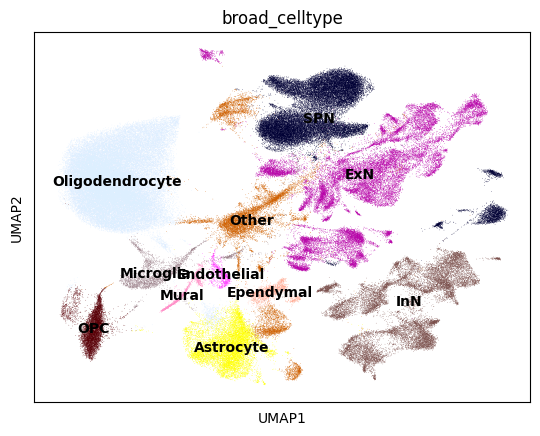

In [9]:
sc.pl.umap(adata, color=['broad_celltype'], legend_loc='on data')

### find cell-types we won't use in analysis
remove them, and then refilter genes based on cell count

In [10]:
found_uncertain = [x for x in adata.obs[celltype_obs_feature].unique().to_list() 
                   if 'uncertain' in x] + ['Astrocyte-GFAP-Hi']
print(found_uncertain)
adata = adata[~adata.obs[celltype_obs_feature].isin(found_uncertain ), :]
sc.pp.filter_genes(adata, min_cells=min_cell_count)
print(adata)

['uncertain', 'uncertain-2', 'uncertain-3', 'Astrocyte-GFAP-Hi']
AnnData object with n_obs × n_vars = 155192 × 34596
    obs: 'pool_name', 'Sample_id', 'Tissue_source', 'Brain_region', 'Clinical_diagnosis', 'Age', 'Sex', 'donor_id', 'lane_num', 'Channel', 'n_genes', 'n_counts', 'percent_mito', 'scale', 'Group', 'leiden_labels', 'anno', 'leiden_labels_085', 'new_anno', 'Age_group', 'broad_celltype'
    var: 'n_cells', 'percent_cells', 'robust', 'highly_variable_features', 'mean', 'var', 'hvf_loess', 'hvf_rank'
    uns: 'Channels', 'Groups', 'PCs', 'W_diffmap', 'W_pca_harmony', 'broad_celltype_colors', 'c2gid', 'df_qcplot', 'diffmap_evals', 'diffmap_knn_distances', 'diffmap_knn_indices', 'genome', 'gncells', 'leiden_resolution', 'modality', 'ncells', 'new_anno_colors', 'norm_count', 'pca', 'pca_features', 'pca_harmony_knn_distances', 'pca_harmony_knn_indices', 'stdzn_max_value', 'stdzn_mean', 'stdzn_std'
    obsm: 'X_diffmap', 'X_fle', 'X_pca', 'X_pca_harmony', 'X_phi', 'X_umap', 'X_umap

### if testing notebooks for debugging purpose subset the features

In [11]:
if testing:
    genes = random.sample(list(adata.var.index.values), testing_sample_size)
    adata = adata[:,genes]
    print(adata)

### compute/prep for the differential expression info

In [12]:
%%time
cmds = {}

for brain_region in brain_regions:
    # only parallelize for memory purposes
    print(f'--- processing {brain_region} in parallel')
    for cell_type in broad_cell_types:
        # subset to just data needed for memory purposes
        adata_sub = subset_ad_by_type(adata, brain_region, cell_type, 'broad_celltype')
        # Create a unique key for each process
        key = f"{brain_region}-{cell_type}"
        p = Process(target=diffexp_group_wrapper,
                    args=(adata_sub, brain_region, cell_type, 'broad_celltype'))
        p.start()
        # Append process and key to keep track
        cmds[key] = p
    # Wait for all processes to finish
    for key, p in cmds.items():
        p.join()

--- processing Middle temporal gyrus in parallel

done with Middle temporal gyrus Ependymal kept 0 features and 6 cells

done with Middle temporal gyrus Endothelial kept 216 features and 170 cells

done with Middle temporal gyrus Mural kept 346 features and 195 cells

done with Middle temporal gyrus Microglia kept 502 features and 258 cells

done with Middle temporal gyrus SPN kept 4727 features and 368 cells

done with Middle temporal gyrus OPC kept 1648 features and 869 cells

done with Middle temporal gyrus Astrocyte kept 2052 features and 867 cells

done with Middle temporal gyrus Oligodendrocyte kept 4462 features and 4287 cells

done with Middle temporal gyrus InN kept 9857 features and 6043 cells

done with Middle temporal gyrus ExN kept 14348 features and 12331 cells
--- processing Putamen in parallel

done with Putamen Ependymal kept 0 features and 12 cells

done with Putamen ExN kept 0 features and 40 cells

done with Putamen Endothelial kept 213 features and 169 cells

done 

In [13]:
# %%time
# cmds = []
# fs_list = []
# for brain_region in brain_regions:
#     for cell_type in broad_cell_types:
#         # cmds.append(diffexp_group(adata, brain_region, cell_type, 'broad_celltype', verbose=DEBUG))
#         with concurrent.futures.ProcessPoolExecutor() as ppe:
#              fs_list.append(ppe.submit(diffexp_group_wrapper, adata, brain_region, 
#                                        cell_type, 'broad_celltype'))
# for future in concurrent.futures.as_completed(fs_list):
#     cmds.append(future.result())

In [14]:
!date

Tue Dec 12 02:49:24 UTC 2023
